# Revenue Analysis Across Mobile Plans for a Telecom Operator

## 📊 Project Overview

**Business Context**: A federal mobile network operator seeks to optimize advertising budget allocation by analyzing customer usage patterns and determining which tariff plan generates higher revenue.

**Dataset**: Sample of 500 users with demographics, subscription details, and complete 2018 usage data (calls, messages, internet sessions).

**Key Business Question**: Which tariff plan (Smart vs Ultra) is more profitable for the operator?

---

## 🎯 Objectives

1. **Revenue Analysis**: Compare total and per-user revenue between Smart and Ultra tariff plans  
2. **Usage Pattern Analysis**: Examine customer behavior across different services (calls, messages, data)  
3. **Churn Analysis**: Investigate customer churn patterns 
4. **Strategic Insights**: Provide data-driven recommendations for advertising budget allocation

## 📁 Data Sources

| Dataset | Records | Description |
|---------|---------|-------------|
| `users.csv` | 500 | User demographics, subscription dates, tariff plans |
| `calls.csv` | ~20k | Call records with duration and dates |
| `messages.csv` | ~80k | SMS/text message records |
| `internet.csv` | ~80k | Internet usage sessions with data consumption |
| `tariffs.csv` | 2 | Tariff plan details and pricing structure |

## 📝 Notes & Assumptions

**Business Rules Applied:**
- Call duration rounded up to nearest minute (company policy)
- Data overage charged per full GB (partial GB rounded up)
- Monthly billing cycles used for revenue aggregation

**Data Quality Considerations:**
- Missing usage data treated as zero usage (non-active users)
- Churn date NULL indicates active subscription through data period
- Age data aggregated into 5-year bins for privacy

**Analytical Limitations:**
- Cost data not available (network costs, customer acquisition costs)
- External factors not considered (competition, market conditions)
- Sample size limited to 500 users (may not represent full customer base)

**Table of contents**    
- Revenue Analysis Across Mobile Plans for a Telecom Operator    
  - 📊 Project Overview    
  - 🎯 Objectives    
  - 📁 Data Sources    
  - Step 1. Data Loading and Initial Exploration    
    - Calls Dataset    
    - Users Dataset    
    - Internet Session Dataset    
    - Messages Dataset    
    - Tariffs Dataset    
    - Data Relationships    
  - Step 2. Monthly Aggregation    
    - Step 1: Extract Time Period    
    - Step 2: Monthly Aggregations by User    
    - Step 3. Create user-month grid    
    - Step 4. Merge Usage Data    
    - Step 5. Calculate excess usage    
    - Step 6. Calculate revenue    
  - Step 3. Exploratory Data Analysis    
    - Revenue Distribution Analysis    
    - Monthly revenue trends    
  - Step 4. Churn Rate Analysis    
    - Basic Churn Rate Calculation    
    - Revenue Patterns of Churned vs Active Customers    
  - Additional question to answer    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [3]:
from pathlib import Path
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def configure_display_settings():
    """
    Configure pandas and numpy display settings for optimal readability.
    
    Settings:
    - Suppresses warnings
    - Disables scientific notation
    - Shows all columns
    - Sets consistent decimal formatting
    """
    # Suppress warnings
    warnings.filterwarnings('ignore')
    
    # Pandas display options
    # Disable scientific notation
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.precision', 2)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    # Numpy display options
    np.set_printoptions(suppress=True, precision=2)
    
    print("✓ Display settings configured")

# Apply configuration
configure_display_settings()

✓ Display settings configured


**Requirements for Telecom Plans Analysis Project**  
pandas==2.3.3  
numpy==2.3.5  
scipy==1.17.0  

**Visualization**  
matplotlib==3.10.7  
seaborn==0.13.2  

**Jupyter environment**  
jupyter>=1.1.0  
ipykernel==7.1.0  
ipython==9.7.0  
notebook>=7.0.0  

## Step 1. Data Loading and Initial Exploration

This project utilizes 5 datasets. Let's load and examine each one:

In [4]:
# Define base data path
DATA_PATH = Path('./data/telecom')

# Load datasets
calls = pd.read_csv(DATA_PATH / 'calls.csv')
internet = pd.read_csv(DATA_PATH / 'internet.csv', index_col=0)
messages = pd.read_csv(DATA_PATH / 'messages.csv')
tariffs = pd.read_csv(DATA_PATH / 'tariffs.csv')
users = pd.read_csv(DATA_PATH / 'users.csv')

**Note on `Unnamed: 0` column** in the internet dataset:

The `Unnamed: 0` column appears when a DataFrame is saved with an index using `pd.DataFrame().to_csv(..., index=True)`. This column can be handled in two ways:

1. **During reading (recommended):** Specify it as the index when loading

2. **After reading:** Drop it manually:
```python
   internet = internet.drop(columns=['Unnamed: 0'])
```
---

Let's create a helper function to display initial data overview and quality metrics:

In [5]:
def show_info(data: pd.DataFrame, name: str = "Dataset") -> None:
    """
    Display initial exploration metrics for a DataFrame.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The dataset to explore
    name : str
        Name of the dataset for display purposes
    """
    print(f"\n{'='*60}")
    print(f"{name.upper()} - Initial Exploration")
    print(f"{'='*60}\n")
    
    # Display first few rows
    display(data.head())
    
    # Show structure and data types
    print("\nDataset Info:")
    data.info()
    
    # Check for duplicates
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
    # By default use all of the columns. Use subset parameter to specify particular columns.
    n_duplicates = data.duplicated().sum()
    print(f"\nDuplicate rows: {n_duplicates}")
    
    # Additional quality checks
    print(f"Missing values per column:")
    missing = data.isnull().sum()
    if missing.sum() > 0:
        display(missing[missing > 0])
    else:
        print("No missing values found")
    
    print(f"\nDataset shape: {data.shape[0]:,} rows × {data.shape[1]} columns")

In [6]:
def check_data_quality(df, categorical_cols, numerical_cols=None):
    """
    Perform comprehensive data quality checks on specified columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to check
    categorical_cols : list
        Columns to check for unique values and anomalies
    numerical_cols : list, optional
        Columns to check for range/outliers

    -----------
    This helper function was developed with Gen AI assistance. There are several comments 
    to explain the logic and checks being performed:
    
    1) When to use \n:
        - At the start of a string when you want a blank line before that print
        - At the end of a string when you want a blank line after that print
        - Use print() alone for a single blank line (cleaner and more explicit)
        This is such GenAI solution but it improves the readability of the output.

    2) Deliberate use of emodjis:
        - "⚠️" for warnings about potential data issues
        - "ℹ️" for informational messages about data characteristics
        - "✓" for successful completion messages
        Another hallmark of GenAI solutions but again I feel it helps to spot 
        problem lines quickly when you glance over the output.

    TO DO: 
        - sanity check for date_time dtype columns

    """
    print("DATA QUALITY CHECKS")
    print("=" * 60)
    
    # Categorical columns
    if categorical_cols:
        print("\nCATEGORICAL COLUMNS:")
        print("-" * 60)
        for col in categorical_cols:
            n_unique = df[col].nunique()
            n_missing = df[col].isnull().sum()
            
            print(f"\n{col.upper()}:")
            print(f"  • Unique values: {n_unique}")
            print(f"  • Sample values: {list(df[col].unique()[:5])}")
            
            # Check for missing values
            if n_missing > 0:
                pct_missing = (n_missing / len(df)) * 100
                print(f"  ⚠️  Missing values: {n_missing} ({pct_missing:.1f}%)")
            
            # Check for potential issues
            if n_unique == 1:
                print(f"  ⚠️  Warning: Only 1 unique value (constant column)")
            elif n_unique == len(df):
                print(f"  ⚠️  Warning: All values unique (potential identifier)")
            
            # Check for empty strings or whitespace
            if df[col].dtype == 'object':
                empty_strings = (df[col].str.strip() == '').sum()
                if empty_strings > 0:
                    print(f"  ⚠️  Empty/whitespace strings: {empty_strings}")
                
                # Check for unusual characters or patterns
                if df[col].str.contains(r'[^\w\s-]', na=False, regex=True).any():
                    print(f"  ℹ️  Contains special characters")
    
    # Numerical columns
    if numerical_cols:
        print(f"\n\nNUMERICAL COLUMNS:")
        print("-" * 60)
        display(df[numerical_cols].describe())
        
        # Check for anomalies in each numerical column
        for col in numerical_cols:
            n_missing = df[col].isnull().sum()
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val = df[col].mean()
            median_val = df[col].median()
            
            print(f"\n{col.upper()} - Anomaly Checks:")
            
            # Missing values
            if n_missing > 0:
                pct_missing = (n_missing / len(df)) * 100
                print(f"  ⚠️  Missing values: {n_missing} ({pct_missing:.1f}%)")
            
            # Negative values
            if min_val < 0:
                n_negative = (df[col] < 0).sum()
                print(f"  ⚠️  Negative values: {n_negative} (min: {min_val})")
            
            # Age-specific checks
            if 'age' in col.lower():
                if min_val < 10:
                    print(f"  ⚠️  Unusually young age detected: {min_val}")
                if max_val > 100:
                    print(f"  ⚠️  Unusually old age detected: {max_val}")
                if min_val < 18:
                    print(f"  ℹ️  Contains minors (age < 18)")
            
            # Check for outliers using IQR method
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            
            if len(outliers) > 0:
                pct_outliers = (len(outliers) / len(df)) * 100
                print(f"  ℹ️  Potential outliers (IQR method): {len(outliers)} ({pct_outliers:.1f}%)")
            
            # Check if mean and median are very different (skewness indicator)
            if abs(mean_val - median_val) > 0.5 * median_val:
                print(f"  ℹ️  Large mean-median difference: mean={mean_val:.2f}, median={median_val:.2f} (skewed distribution)")
    
    print("\n" + "=" * 60)
    print("✓ Quality check complete")

### Calls Dataset

In [7]:
show_info(calls, "Calls Dataset")


CALLS DATASET - Initial Exploration



,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Duplicate rows: 0
Missing values per column:
No missing values found

Dataset shape: 202,607 rows × 4 columns


**1. Calls Dataset**  

**Description:** Contains information about phone calls made by users.

| Column | Description | Data Type | Notes |
|--------|-------------|-----------|-------|
| `id` | Unique call identifier | int | Rename for clarity |
| `call_date` | Date of the call | object → datetime | Requires type conversion |
| `duration` | Call duration in minutes | float → int | Will be rounded up to whole minutes per company policy |
| `user_id` | User identifier who made the call | int | Foreign key to users table |

**Data Quality Notes:**
- ✓ No missing values detected  
- ⚠️ `call_date` needs conversion to datetime format
- ⚠️ `duration` should be rounded to integers (company rounds even 1-second calls to full minutes)

In [8]:
# Data cleaning: Calls dataset
calls = calls.rename(columns={'id': 'call_id'})  # Rename for clarity
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = np.ceil(calls['duration']).astype(int)  # Round up and convert to integer

In [9]:
# TO DO - think about sanity check for date_time dtype columns

check_data_quality(
    df=calls,
    categorical_cols=['user_id'],
    numerical_cols=['duration']
)

DATA QUALITY CHECKS

CATEGORICAL COLUMNS:
------------------------------------------------------------

USER_ID:
  • Unique values: 492
  • Sample values: [np.int64(1000), np.int64(1001), np.int64(1002), np.int64(1003), np.int64(1004)]


NUMERICAL COLUMNS:
------------------------------------------------------------


,duration
count,202607.00
mean,7.16
std,5.96
min,0.00
25%,2.00
50%,6.00
75%,11.00
max,38.00



DURATION - Anomaly Checks:
  ℹ️  Potential outliers (IQR method): 1041 (0.5%)

✓ Quality check complete


8 users didn't utilize calls service

### Users Dataset

In [10]:
show_info(users, "Users Dataset")


USERS DATASET - Initial Exploration



,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Duplicate rows: 0
Missing values per column:


churn_date    462
dtype: int64


Dataset shape: 500 rows × 8 columns


**2. Users Dataset**

**Description:** Contains user demographic and subscription information.

| Column | Description | Data Type | Notes |
|--------|-------------|-----------|-------|
| `user_id` | Unique user identifier | int | Primary key |
| `first_name` | User's first name | object | |
| `last_name` | User's last name | object | |
| `age` | User's age in years | int | |
| `reg_date` | Plan activation date | object → datetime | Requires type conversion |
| `churn_date` | Plan cancellation date | object → datetime | NULL if plan still active |
| `city` | User's city of residence | object | |
| `tariff` | Tariff plan name | object | Foreign key to tariffs table |

**Data Quality Notes:**
- ✓ Missing values in `churn_date` are expected (active subscriptions)
- ⚠️ Date columns need conversion to datetime format
- ✓ All other columns are clean


In [11]:
# Apply to users dataset
check_data_quality(
    users, 
    categorical_cols=['user_id', 'first_name', 'last_name', 'city', 'tariff'],
    numerical_cols=['age']
)

DATA QUALITY CHECKS

CATEGORICAL COLUMNS:
------------------------------------------------------------

USER_ID:
  • Unique values: 500
  • Sample values: [np.int64(1000), np.int64(1001), np.int64(1002), np.int64(1003), np.int64(1004)]
  ⚠️  Warning: All values unique (potential identifier)

FIRST_NAME:
  • Unique values: 246
  • Sample values: ['Рафаил', 'Иван', 'Евгений', 'Белла', 'Татьяна']

LAST_NAME:
  • Unique values: 419
  • Sample values: ['Верещагин', 'Ежов', 'Абрамович', 'Белякова', 'Авдеенко']

CITY:
  • Unique values: 76
  • Sample values: ['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк', 'Набережные Челны']

TARIFF:
  • Unique values: 2
  • Sample values: ['ultra', 'smart']


NUMERICAL COLUMNS:
------------------------------------------------------------


,age
count,500.00
mean,46.59
std,16.67
min,18.00
25%,32.00
50%,46.00
75%,62.00
max,75.00



AGE - Anomaly Checks:

✓ Quality check complete


- We have 492 unique user IDs in the calls dataset and 500 in the users dataset. 

In [12]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

For privacy reasons, we drop first name and last name column, and replace exact age with age bin:

In [13]:
users = users.drop(columns=['first_name', 'last_name'])

# Create 5-year age bins (e.g., 15-19, 20-24, 65-69, etc.)
age_bins = range(10, 101, 5)  
age_labels = [f"{i}-{i+4}" for i in age_bins[:-1]]
users['age_group'] = pd.cut(users['age'], bins=age_bins, labels=age_labels, right=False)


### Internet Session Dataset

In [14]:
show_info(internet, "Internet Usage Dataset")


INTERNET USAGE DATASET - Initial Exploration



,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB

Duplicate rows: 0
Missing values per column:
No missing values found

Dataset shape: 149,396 rows × 4 columns


**3. Internet Sessions Dataset**  

**Description:** Contains information about internet usage sessions.

| Column | Description | Data Type | Notes |
|--------|-------------|-----------|-------|
| `id` | Unique session identifier | int |  |
| `mb_used` | Data consumed per session (MB) | float | |
| `session_date` | Date of internet session | object → datetime | Requires type conversion |
| `user_id` | User identifier | int | Foreign key to users table |

**Data Quality Notes:**
- ✓ No missing values detected
- ⚠️ `session_date` needs conversion to datetime format

In [15]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')

internet = internet.rename(columns={'id': 'session_id'})  # Rename for clarity

### Messages Dataset

In [16]:
show_info(messages, "Messages Dataset")


MESSAGES DATASET - Initial Exploration



,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Duplicate rows: 0
Missing values per column:
No missing values found

Dataset shape: 123,036 rows × 3 columns


In [17]:
check_data_quality(df=messages, 
    categorical_cols=['user_id', 'id'])

DATA QUALITY CHECKS

CATEGORICAL COLUMNS:
------------------------------------------------------------

USER_ID:
  • Unique values: 426
  • Sample values: [np.int64(1000), np.int64(1002), np.int64(1003), np.int64(1004), np.int64(1005)]

ID:
  • Unique values: 123036
  • Sample values: ['1000_0', '1000_1', '1000_2', '1000_3', '1000_4']
  ⚠️  Warning: All values unique (potential identifier)

✓ Quality check complete


**4. Messages Dataset**  

**Description:** Contains information about SMS/text messages sent by users.

| Column | Description | Data Type | Notes |
|--------|-------------|-----------|-------|
| `id` | Unique message identifier | int | Rename to the message_id |
| `message_date` | Date message was sent | object → datetime | Requires type conversion |
| `user_id` | User identifier who sent message | int | Foreign key to users table |

**Data Quality Notes:**
- ✓ No missing values detected
- ⚠️ `message_date` needs conversion to datetime format
- `id` column will be renamed to 'message_id'

In [18]:
# Convert date columns to datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
# Verify conversion
print(f"✓ message_date converted to {messages['message_date'].dtype}")

messages = messages.rename(columns={'id': 'message_id'})  # Rename for clarity

✓ message_date converted to datetime64[ns]


### Tariffs Dataset

In [19]:
show_info(tariffs, "Tariffs Dataset")


TARIFFS DATASET - Initial Exploration



,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 260.0+ bytes

Duplicate rows: 0
Missing values per column:
No missing values found

Dataset shape: 2 rows × 8 columns


**5. Tariffs Dataset**  

**Description:** Contains tariff plan details and pricing structure.

| Column | Description | Data Type | Notes |
|--------|-------------|-----------|-------|
| `tariff_name` | Name of the tariff plan | object | Primary key |
| `rub_monthly_fee` | Monthly subscription fee (RUB) | float | |
| `minutes_included` | Included minutes per month | int | |
| `messages_included` | Included messages per month | int | |
| `mb_per_month_included` | Included data per month (MB) | int | |
| `rub_per_minute` | Cost per additional minute (RUB) | float | Charged when exceeding included minutes |
| `rub_per_message` | Cost per additional message (RUB) | float | Charged when exceeding included messages |
| `rub_per_gb` | Cost per additional GB (RUB) | float | Charged when exceeding included data |

**Data Quality Notes:**
- ✓ No missing values detected
- ✓ All columns are in correct format


### Data Relationships

users (1) ----< (M) calls  
users (1) ----< (M) internet  
users (1) ----< (M) messages  
users (M) >---- (1) tariffs  

## Step 2. Monthly Aggregation

Revenue analysis for telecom operators requires monthly aggregation for several strategic reasons:  
- Tariff plans operate on monthly billing cycles  
- Strategic decisions (marketing budget allocation, tariff adjustments) operate on monthly or quarterly timescales  
- Daily fluctuations in usage are noise for strategic analysis  
- Data volume management:  
    - Reduces dataset size while preserving analytical value  
    - Individual call/session records: ~200k+ rows
    - Monthly user aggregations: ~6,000 rows (500 users × 12 months)
97% reduction in data volume with no loss of business insights

### Step 1: Extract Time Period

In [20]:
# Extract year-month period for grouping
# Using Period ensures months are treated correctly across years
calls['period'] = calls['call_date'].dt.to_period('M')
internet['period'] = internet['session_date'].dt.to_period('M')
messages['period'] = messages['message_date'].dt.to_period('M')

In [21]:
# Verify period extraction
print(f"Date range in data:\n")
print(f"  Calls: {calls['call_date'].min()} to {calls['call_date'].max()}")
print(f"  Internet: {internet['session_date'].min()} to {internet['session_date'].max()}")
print(f"  Messages: {messages['message_date'].min()} to {messages['message_date'].max()}\n")

# Verify period extraction
print(f"Period range in data:\n")
print(f"  Calls: {calls['period'].min()} to {calls['period'].max()}")
print(f"  Internet: {internet['period'].min()} to {internet['period'].max()}")
print(f"  Messages: {messages['period'].min()} to {messages['period'].max()}")


Date range in data:

  Calls: 2018-01-01 00:00:00 to 2018-12-31 00:00:00
  Internet: 2018-01-01 00:00:00 to 2018-12-31 00:00:00
  Messages: 2018-01-02 00:00:00 to 2018-12-31 00:00:00

Period range in data:

  Calls: 2018-01 to 2018-12
  Internet: 2018-01 to 2018-12
  Messages: 2018-01 to 2018-12


Why to use Period pandas object:  
 - Encodes year+month as a single period object (e.g. 2018-06) so grouping/resampling by month preserves year boundaries (2018-01 ≠ 2019-01).  
- Less error‑prone than grouping by .dt.month (which loses year).  

Docs: [Pandas Period](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-period-aliases)

### Step 2: Monthly Aggregations by User

In [22]:
# Aggregate calls data
# Sum total minutes and count number of calls per user per month
calls_monthly = calls.groupby(['user_id', 'period'], as_index=False).agg(
    total_minutes=('duration', 'sum'),
    num_calls=('call_id', 'count')
)

print(f"\n✓ Calls aggregated:")
print(f"  • User-months: {calls_monthly.shape[0]:,}")
print(f"  • Unique users: {calls_monthly['user_id'].nunique()}")
print(f"  • Unique months: {calls_monthly['period'].nunique()}")


✓ Calls aggregated:
  • User-months: 3,174
  • Unique users: 492
  • Unique months: 12


In [23]:
# Aggregate internet data
# Sum total MB used and count number of sessions
internet_monthly = internet.groupby(['user_id', 'period'], as_index=False).agg(
    total_mb=('mb_used', 'sum'),
    num_sessions=('session_id', 'count')
)

print(f"\n✓ Internet aggregated:")
print(f"  • User-months: {internet_monthly.shape[0]:,}")
print(f"  • Unique users: {internet_monthly['user_id'].nunique()}")
print(f"  • Unique months: {internet_monthly['period'].nunique()}")


✓ Internet aggregated:
  • User-months: 3,203
  • Unique users: 497
  • Unique months: 12


In [24]:
# Aggregate messages data
# Count number of messages sent
messages_monthly = messages.groupby(['user_id', 'period'], as_index=False).agg(
    num_messages=('message_id', 'count')
)

print(f"\n✓ Messages aggregated:")
print(f"  • User-months: {messages_monthly.shape[0]:,}")
print(f"  • Unique users: {messages_monthly['user_id'].nunique()}")
print(f"  • Unique months: {messages_monthly['period'].nunique()}")


✓ Messages aggregated:
  • User-months: 2,717
  • Unique users: 426
  • Unique months: 12


### Step 3. Create user-month grid

In [25]:
# Get date range from actual data across all datasets
date_columns = [
    calls['call_date'],
    internet['session_date'], 
    messages['message_date']
]

# Find overall min and max dates across all datasets
min_date = min(col.min() for col in date_columns)
max_date = max(col.max() for col in date_columns)

print(f"Data spans from {min_date.date()} to {max_date.date()}")

# Create period range based on actual data
all_months = pd.period_range(
    start=min_date.to_period('M'), 
    end=max_date.to_period('M'), 
    freq='M'
)

print(f"Period range: {all_months[0]} to {all_months[-1]} ({len(all_months)} months)")

Data spans from 2018-01-01 to 2018-12-31
Period range: 2018-01 to 2018-12 (12 months)


In [26]:
# Create user-month combinations only for active subscription periods
user_month_list = []

for _, user in users.iterrows():
    user_id = user['user_id']
    reg_date = user['reg_date']
    churn_date = user['churn_date']
    
    # Convert reg_date to period
    start_period = reg_date.to_period('M')
    
    # Handle churn_date - if NaN (still active), use end of data period
    if pd.isna(churn_date):
        end_period = all_months[-1]  # Use last month from all_months
    else:
        end_period = churn_date.to_period('M')
    
    # Create periods for this user's active months
    user_periods = pd.period_range(start=start_period, end=end_period, freq='M')
    
    # Only include periods that are within our data range, filter out the months before needed period
    user_periods = [p for p in user_periods if p in all_months]
    
    # Add to list
    for period in user_periods:
        user_month_list.append({'user_id': user_id, 'period': period})

# Convert to DataFrame
user_month_grid = pd.DataFrame(user_month_list)

In [27]:
print(f"\n✓ Filtered user-month grid created:")
print(f"  • Active user-months: {user_month_grid.shape[0]:,}")
print(f"  • Unique users: {user_month_grid['user_id'].nunique()}")
print(f"  • Unique months: {user_month_grid['period'].nunique()}")


✓ Filtered user-month grid created:
  • Active user-months: 3,216
  • Unique users: 500
  • Unique months: 12


All 500 users have active subscription, however, not everyone uses it - we can see in monthly usage data that number of unique users is less than 500. For correct calculation of revenue capturing the subscription revenue and the variable usage-based revenue, we need to leftjoin user-month grid with usage data.

### Step 4. Merge Usage Data

In [28]:
revenue_data = user_month_grid.merge(calls_monthly, on=['user_id', 'period'], how='left') 
revenue_data = revenue_data.merge(internet_monthly, on=['user_id', 'period'], how='left')
revenue_data = revenue_data.merge(messages_monthly, on=['user_id', 'period'], how='left')
revenue_data = revenue_data.merge(users[['user_id', 'age_group', 'city', 'tariff']], on='user_id', how='left')
revenue_data = revenue_data.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')
revenue_data = revenue_data.drop(columns=['tariff_name'])

revenue_data.head()

,user_id,period,total_minutes,num_calls,total_mb,num_sessions,num_messages,age_group,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05,159.00,22.00,2253.49,5.00,22.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06,172.00,43.00,23233.77,49.00,60.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07,340.00,47.00,14003.64,29.00,75.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08,408.00,52.00,14055.93,29.00,81.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09,466.00,58.00,14568.91,27.00,57.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1


### Step 5. Calculate excess usage

In [29]:
# Fill missing usage values with 0 (users who didn't use services)
revenue_data['total_minutes'] = revenue_data['total_minutes'].fillna(0)
revenue_data['total_mb'] = revenue_data['total_mb'].fillna(0)
revenue_data['num_messages'] = revenue_data['num_messages'].fillna(0)

# Calculate excess usage for each service
revenue_data['excess_minutes'] = (revenue_data['total_minutes'] - revenue_data['minutes_included']).clip(lower=0)
revenue_data['excess_mb'] = (revenue_data['total_mb'] - revenue_data['mb_per_month_included']).clip(lower=0)
revenue_data['excess_messages'] = (revenue_data['num_messages'] - revenue_data['messages_included']).clip(lower=0)

In [30]:
# Function to convert excess MB to billable GB
def excess_mb_to_gb(excess_mb):
    """Convert excess MB to GB, rounding up any partial GB"""
    if excess_mb <= 0:
        return 0
    excess_gb = excess_mb // 1024
    if excess_mb % 1024 > 0:
        excess_gb += 1
    return int(excess_gb)

# Convert excess MB to billable GB
revenue_data['excess_gb'] = revenue_data['excess_mb'].apply(excess_mb_to_gb)

### Step 6. Calculate revenue

In [31]:
# Simplified revenue calculation function
def calculate_revenue(row):
    """Calculate total monthly revenue from a user"""
    total_revenue = row['rub_monthly_fee']  # Base monthly fee
    
    # Add overage charges
    total_revenue += row['excess_minutes'] * row['rub_per_minute']
    total_revenue += row['excess_gb'] * row['rub_per_gb']
    total_revenue += row['excess_messages'] * row['rub_per_message']
    
    return total_revenue

# Calculate revenue for each user-month
revenue_data['monthly_revenue'] = revenue_data.apply(calculate_revenue, axis=1)

In [32]:
revenue_data.head()

,user_id,period,total_minutes,num_calls,total_mb,num_sessions,num_messages,age_group,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,excess_minutes,excess_mb,excess_messages,excess_gb,monthly_revenue
0,1000,2018-05,159.00,22.00,2253.49,5.00,22.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00,0,1950.00
1,1000,2018-06,172.00,43.00,23233.77,49.00,60.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00,0,1950.00
2,1000,2018-07,340.00,47.00,14003.64,29.00,75.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00,0,1950.00
3,1000,2018-08,408.00,52.00,14055.93,29.00,81.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00,0,1950.00
4,1000,2018-09,466.00,58.00,14568.91,27.00,57.00,50-54,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00,0,1950.00


## Step 3. Exploratory Data Analysis

### Revenue Distribution Analysis
Examine overall revenue distribution across all users and months

Analyze monthly revenue trends over the 2018 period

Research Question: Which tariff plan is more profitable for the operator?")

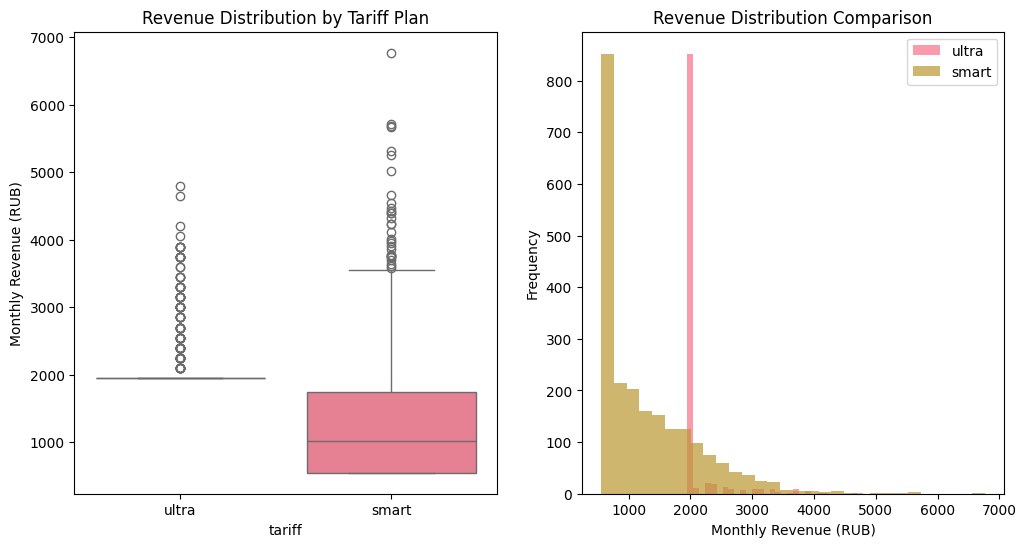

In [33]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Visualization: Revenue distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Revenue distribution by tariff (box plot)
sns.boxplot(data=revenue_data, x='tariff', y='monthly_revenue', ax=axes[0])
axes[0].set_title('Revenue Distribution by Tariff Plan')
axes[0].set_ylabel('Monthly Revenue (RUB)')

# Revenue histogram comparison
for tariff in revenue_data['tariff'].unique():
    tariff_data = revenue_data[revenue_data['tariff'] == tariff]['monthly_revenue']
    axes[1].hist(tariff_data, alpha=0.7, label=tariff, bins=30)
axes[1].set_title('Revenue Distribution Comparison')
axes[1].set_xlabel('Monthly Revenue (RUB)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

The Smart tariff has a lower median monthly revenue compared to the Ultra tariff, alongside greater dispersion and a longer right tail, indicating higher variability and more extreme high-end values. In contrast, the Ultra tariff shows a higher median revenue with a more compact distribution and fewer extreme outliers.

In [34]:
tariff_stats = revenue_data.groupby('tariff')['monthly_revenue'].agg([
    'count',    # Number of user-months
    'sum',      # Total revenue
    'mean',     # Average revenue per user-month
    'median',   # Median revenue
    'std',      # Revenue variability
    'min',      # Minimum revenue
    'max'       # Maximum revenue
]).round(2)

tariff_stats.columns = ['User_Months', 'Total_Revenue_RUB', 'Mean_Revenue_RUB', 
                       'Median_Revenue_RUB', 'Std_Revenue_RUB', 'Min_Revenue_RUB', 'Max_Revenue_RUB']

# Calculate additional metrics
tariff_stats['Unique_Users'] = revenue_data.groupby('tariff')['user_id'].nunique()
tariff_stats['Avg_Revenue_Per_User'] = tariff_stats['Total_Revenue_RUB'] / tariff_stats['Unique_Users']

print("Key Profitability Metrics by Tariff Plan:")
display(tariff_stats)

Key Profitability Metrics by Tariff Plan:


,User_Months,Total_Revenue_RUB,Mean_Revenue_RUB,Median_Revenue_RUB,Std_Revenue_RUB,Min_Revenue_RUB,Max_Revenue_RUB,Unique_Users,Avg_Revenue_Per_User
tariff,,,,,,,,,
smart,2230,2875901.00,1289.64,1021.00,818.37,550.00,6770.00,351,8193.45
ultra,986,2041050.00,2070.03,1950.00,376.02,1950.00,4800.00,149,13698.32


The Smart tariff generates higher total revenue (2.88M RUB) and serves a substantially larger user base (351 users vs. 149), but its revenue per user is considerably lower (8.2k RUB on average). In contrast, the Ultra tariff produces lower total revenue overall (2.04M RUB) but achieves significantly higher average and median revenue per user (13.7k and 1.95k RUB, respectively), indicating a smaller yet higher-value customer segment.

In [35]:
# Calculate base fees vs overage revenue
revenue_data['base_fee_revenue'] = revenue_data['rub_monthly_fee']
revenue_data['extra_revenue'] = (
    revenue_data['excess_minutes'] * revenue_data['rub_per_minute'] +
    revenue_data['excess_gb'] * revenue_data['rub_per_gb'] +
    revenue_data['excess_messages'] * revenue_data['rub_per_message']
)

# Revenue composition by tariff
composition_stats = revenue_data.groupby('tariff').agg({
    'base_fee_revenue': ['sum', 'mean'],
    'extra_revenue': ['sum', 'mean'],
    'monthly_revenue': 'sum'
}).round(2)

composition_stats.columns = ['Base_Fee_Total', 'Base_Fee_Avg', 'Extra_Total', 'Extra_Avg', 'Total_Revenue']
composition_stats['Extra_Percentage'] = (composition_stats['Extra_Total'] / composition_stats['Total_Revenue'] * 100).round(1)

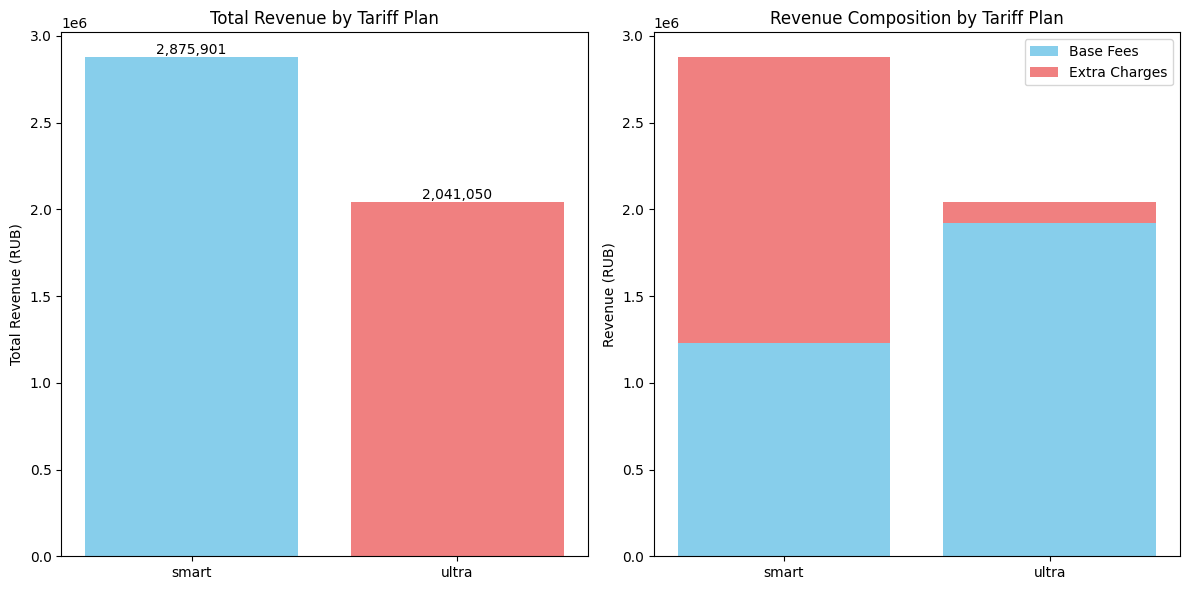

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Total revenue by tariff (bar chart)
total_revenue_by_tariff = tariff_stats['Total_Revenue_RUB']
axes[0].bar(total_revenue_by_tariff.index, total_revenue_by_tariff.values, color=['skyblue', 'lightcoral'])
axes[0].set_title('Total Revenue by Tariff Plan')
axes[0].set_ylabel('Total Revenue (RUB)')
for i, v in enumerate(total_revenue_by_tariff.values):
    axes[0].text(i, v + 1000, f'{v:,.0f}', ha='center', va='bottom')


# Revenue composition stacked bar chart
tariffs = composition_stats.index
base_fees = composition_stats['Base_Fee_Total']
extra_fees = composition_stats['Extra_Total']

axes[1].bar(tariffs, base_fees, label='Base Fees', color='skyblue')
axes[1].bar(tariffs, extra_fees, bottom=base_fees, label='Extra Charges', color='lightcoral')
axes[1].set_title('Revenue Composition by Tariff Plan')
axes[1].set_ylabel('Revenue (RUB)')
axes[1].legend()
plt.tight_layout()
plt.show()

Although the Smart tariff produces higher overall revenue, its revenue structure is heavily dependent on overage charges, whereas the Ultra tariff relies more on stable base fees.

### Monthly revenue trends

In [37]:
# Monthly revenue trends analysis
monthly_trends = revenue_data.groupby(['period', 'tariff']).agg({
    'monthly_revenue': ['sum', 'mean', 'count'],
    'user_id': 'nunique'
}).round(2)

monthly_trends.columns = ['Total_Revenue', 'Avg_Revenue_Per_User', 'User_Months', 'Unique_Users']
monthly_trends = monthly_trends.reset_index()

# Overall monthly trends (all tariffs combined)
overall_monthly = revenue_data.groupby('period').agg({
    'monthly_revenue': ['sum', 'mean'],
    'user_id': 'nunique'
}).round(2)
overall_monthly.columns = ['Total_Revenue', 'Avg_Revenue_Per_User', 'Active_Users']

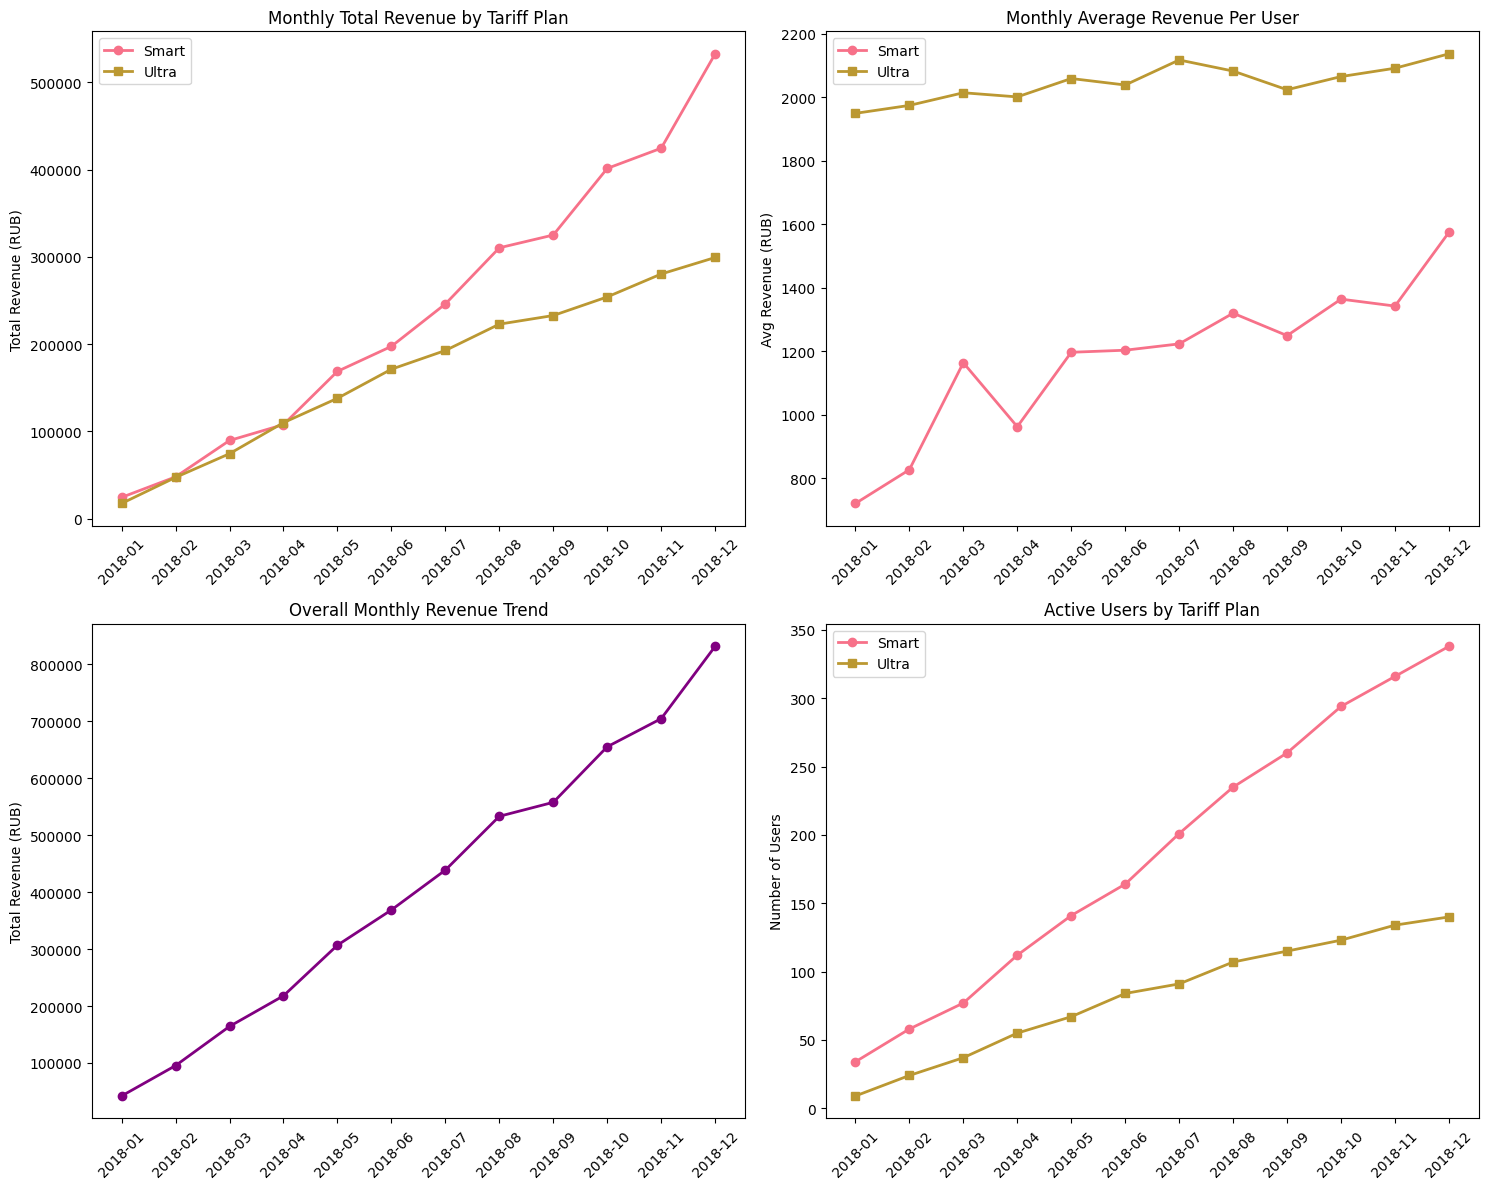

In [38]:
# Visualization: Monthly revenue trends
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total monthly revenue by tariff plan
smart_monthly = monthly_trends[monthly_trends['tariff'] == 'smart']
ultra_monthly = monthly_trends[monthly_trends['tariff'] == 'ultra']

axes[0, 0].plot(smart_monthly['period'].astype(str), smart_monthly['Total_Revenue'], 
                marker='o', label='Smart', linewidth=2)
axes[0, 0].plot(ultra_monthly['period'].astype(str), ultra_monthly['Total_Revenue'], 
                marker='s', label='Ultra', linewidth=2)
axes[0, 0].set_title('Monthly Total Revenue by Tariff Plan')
axes[0, 0].set_ylabel('Total Revenue (RUB)')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average revenue per user by tariff
axes[0, 1].plot(smart_monthly['period'].astype(str), smart_monthly['Avg_Revenue_Per_User'], 
                marker='o', label='Smart', linewidth=2)
axes[0, 1].plot(ultra_monthly['period'].astype(str), ultra_monthly['Avg_Revenue_Per_User'], 
                marker='s', label='Ultra', linewidth=2)
axes[0, 1].set_title('Monthly Average Revenue Per User')
axes[0, 1].set_ylabel('Avg Revenue (RUB)')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Overall market trends
axes[1, 0].plot(overall_monthly.index.astype(str), overall_monthly['Total_Revenue'], 
                marker='o', color='purple', linewidth=2)
axes[1, 0].set_title('Overall Monthly Revenue Trend')
axes[1, 0].set_ylabel('Total Revenue (RUB)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Active user count trends
axes[1, 1].plot(smart_monthly['period'].astype(str), smart_monthly['Unique_Users'], 
                marker='o', label='Smart', linewidth=2)
axes[1, 1].plot(ultra_monthly['period'].astype(str), ultra_monthly['Unique_Users'], 
                marker='s', label='Ultra', linewidth=2)
axes[1, 1].set_title('Active Users by Tariff Plan')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Monthly Total Revenue by Tariff**
- Smart tariff shows faster and steeper growth in total monthly revenue.  

**Monthly Average Revenue Per User (ARPU)**  
- Ultra users generate consistently higher and more predictable revenue per user, whereas Smart users contribute lower but gradually increasing ARPU with greater variability. 
 
**Overall Monthly Revenue Trend**  
- Overall revenue increases steadily across the year, accelerating in later months.
- The curve closely mirrors Smart tariff growth.  

**Active Users by Tariff**  
- Smart user base grows rapidly and consistently.
- Ultra user growth is slower and remains significantly smaller.  

Revenue growth over the year is driven primarily by the Smart tariff through rapid user base expansion and increasing usage-based charges. While Ultra users generate higher and more stable revenue per user, their smaller and slower-growing user base limits total revenue contribution. This highlights a trade-off between scale-driven growth (Smart) and value-driven stability (Ultra).  

**Research Question: Which tariff plan is more profitable for the operator?")**  

The Smart tariff is currently more profitable in terms of total revenue generation, primarily due to its larger and growing user base and substantial contribution from usage-based extra charges. However, the Ultra tariff is more profitable on a per-user basis. True profitability cannot be fully assessed without cost data (e.g., network usage costs, customer acquisition costs, support costs).

## Step 4. Churn Rate Analysis

### Basic Churn Rate Calculation

In [39]:
# First, let's identify churned vs active customers
users_churn_analysis = users.copy()

# Create churn indicator
users_churn_analysis['is_churned'] = ~users_churn_analysis['churn_date'].isna()

# Calculate subscription duration for all users
users_churn_analysis['subscription_end_date'] = users_churn_analysis['churn_date'].fillna(pd.Timestamp('2018-12-31'))
users_churn_analysis['subscription_duration_days'] = (
    users_churn_analysis['subscription_end_date'] - users_churn_analysis['reg_date']
).dt.days

print("=== CHURN OVERVIEW ===")
print(f"Total customers: {len(users_churn_analysis)}")
print(f"Churned customers: {users_churn_analysis['is_churned'].sum()}")
print(f"Active customers: {(~users_churn_analysis['is_churned']).sum()}")
print(f"Overall churn rate: {users_churn_analysis['is_churned'].mean():.1%}")

=== CHURN OVERVIEW ===
Total customers: 500
Churned customers: 38
Active customers: 462
Overall churn rate: 7.6%


In [40]:
### Churn Rate by Tariff Plan

churn_by_tariff = users_churn_analysis.groupby('tariff').agg({
    'is_churned': ['count', 'sum', 'mean'],
    'subscription_duration_days': 'mean'
}).round(3)

churn_by_tariff.columns = ['Total_Customers', 'Churned_Customers', 'Churn_Rate', 'Avg_Subscription_Days']
churn_by_tariff['Active_Customers'] = churn_by_tariff['Total_Customers'] - churn_by_tariff['Churned_Customers']
churn_by_tariff['Churn_Rate_Pct'] = (churn_by_tariff['Churn_Rate'] * 100).round(1)

display(churn_by_tariff)

,Total_Customers,Churned_Customers,Churn_Rate,Avg_Subscription_Days,Active_Customers,Churn_Rate_Pct
tariff,,,,,,
smart,351,23,0.07,177.65,328,6.60
ultra,149,15,0.10,184.08,134,10.10


### Revenue Patterns of Churned vs Active Customers

In [41]:
# Get average revenue per user for churned vs active customers
user_revenue_summary = revenue_data.groupby('user_id').agg({
    'monthly_revenue': ['mean', 'sum', 'count'],
    'extra_revenue': 'mean',
    'base_fee_revenue': 'mean'
}).round(2)

user_revenue_summary.columns = ['Avg_Monthly_Revenue', 'Total_Revenue', 'Active_Months', 
                               'Avg_Extra_Revenue', 'Avg_Base_Fee_Revenue']

# Merge with churn data
churn_revenue_analysis = users_churn_analysis[['user_id', 'tariff', 'is_churned']].merge(
    user_revenue_summary, left_on='user_id', right_index=True, how='left'
)

print("=== REVENUE COMPARISON: CHURNED vs ACTIVE CUSTOMERS ===")
churn_revenue_comparison = churn_revenue_analysis.groupby(['tariff', 'is_churned']).agg({
    'Avg_Monthly_Revenue': 'mean',
    'Total_Revenue': 'mean', 
    'Active_Months': 'mean',
    'Avg_Extra_Revenue': 'mean'
}).round(2)

display(churn_revenue_comparison)

=== REVENUE COMPARISON: CHURNED vs ACTIVE CUSTOMERS ===


Avg_Monthly_Revenue  Total_Revenue  Active_Months  \
tariff is_churned                                                      
smart  False                   1348.71        8391.22           6.46   
       True                     944.06        5373.13           4.87   
ultra  False                   2087.26       14021.64           6.78   
       True                    2070.25       10810.00           5.13   

                   Avg_Extra_Revenue  
tariff is_churned                     
smart  False                  798.71  
       True                   394.06  
ultra  False                  137.26  
       True                   120.25

In [42]:
### Statistical Significance Testing


print("=== STATISTICAL TESTS FOR CHURN DIFFERENCES ===\n")

# 1. Test if churn rates differ between tariff plans
smart_churn = users_churn_analysis[users_churn_analysis['tariff'] == 'smart']['is_churned']
ultra_churn = users_churn_analysis[users_churn_analysis['tariff'] == 'ultra']['is_churned']

# Chi-square test for churn rate differences
contingency_table = pd.crosstab(users_churn_analysis['tariff'], users_churn_analysis['is_churned'])
chi2, p_value_churn = stats.chi2_contingency(contingency_table)[:2]

print("1. Churn Rate Difference Between Tariff Plans:")
print(f"   Chi-square statistic: {chi2:.4f}")
print(f"   P-value: {p_value_churn:.4f}")
print(f"   Result: {'Significant' if p_value_churn < 0.05 else 'Not significant'} difference")

=== STATISTICAL TESTS FOR CHURN DIFFERENCES ===

1. Churn Rate Difference Between Tariff Plans:
   Chi-square statistic: 1.3733
   P-value: 0.2413
   Result: Not significant difference


## Additional question to answer

**Usage Pattern Analysis**
* Analyze usage distribution for each service (calls, messages, data)
* Calculate percentage of users exceeding included allowances by tariff
* Identify heavy users vs. light users within each plan
* Examine correlation between different types of usage
* Do customers who frequently exceed allowances churn more?
* Are customers with consistent base-fee-only usage more loyal?
* Analyze churn correlation with overage charges


**Customer Segmentation**
* Segment users by demographics (age groups, cities) and analyze revenue patterns
* Identify high-value customer profiles
* Analyze usage patterns by customer segments


**Revenue Composition Analysis**
* Break down revenue sources: base fees vs. overage charges
* Identify which services drive overage revenue most
* Analyze revenue predictability vs. variability

**Statistical Testing**
* Perform hypothesis testing to determine if revenue differences between plans are statistically significant

